# J2KB 나나길 프로젝트 : 작사가 인공지능 만들기 실습

---

## 실습에 사용되는 곡 (체크표시가 되어 있는 곡)

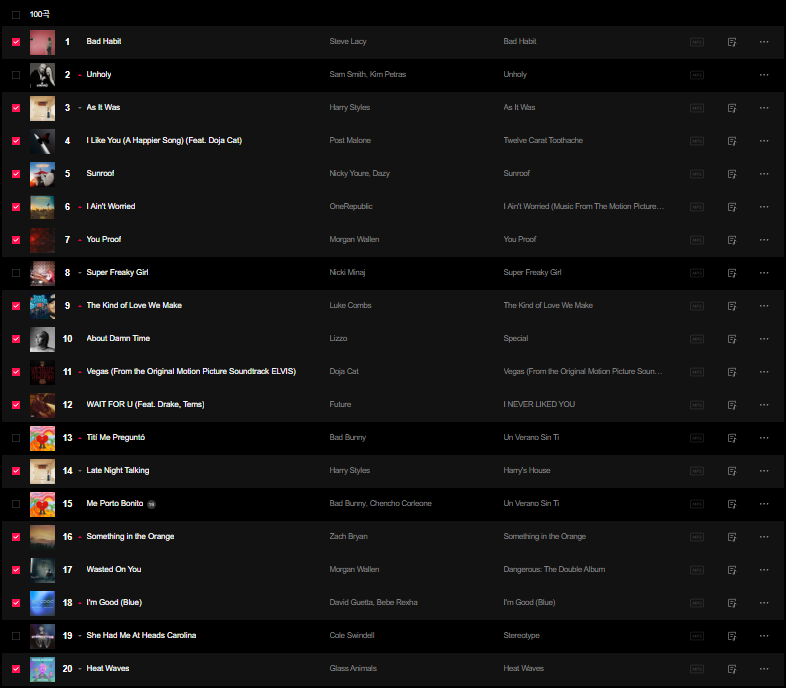

---

작업을 시작하기에 앞서 tensorflow를 설치하지 않은 환경이라면, 먼저 설치를 하고 진행해야 아래 코드에 오류가 생기지 않을 것이다.

설치에 시간이 꽤 걸릴 수 있으니, 편안하게 기다렸다가 시작하자.

In [1]:
## !pip install tensorflow

## 데이터 불러오기

In [2]:
# 프로젝트에 사용할 모듈 및 데이터 불러오기

import glob
import re
import numpy as np
import tensorflow as tf

txt_file_path = '7th_lyrics/*'

txt_list = glob.glob(txt_file_path)

In [3]:
# 불러온 모든 txt 파일을 raw_corpus 라는 리스트에 문장 단위로 저장하기

raw_corpus = []

for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터의 크기 :", len(raw_corpus))
print("예문 : \n", raw_corpus[:6])

데이터의 크기 : 848
예문 : 
 ['(Anyway)', '', "It's bad bitch o'clock, yeah, it's thick-thirty", "I've been through a lot but I'm still flirty (okay)", "Is everybody back up in the buildin'?", "It's been a minute, tell me how you're healin'"]


## 데이터 정제

In [4]:
corpus = []

for idx, sentence in enumerate(raw_corpus):
    if len(sentence) == 0: continue           # 길이가 0인 문장 제외
    if ('[' and ']') in sentence: continue    # 대괄호가 들어가는 문장 제외
    
    corpus.append(sentence)


print(f'원래 데이터 크기 : {len(raw_corpus)}')
print(f'공백인 문장, 대괄호 포함된 문장 제외한 데이터의 크기 : {len(corpus)}')

corpus = list(set(corpus))          # 중복불가한 set의 특성을 이용하여 중복되는 문장 제외 후 다시 리스트로 변환
print(f'중복되는 문장 제외한 데이터 크기 : {len(corpus)}')

원래 데이터 크기 : 848
공백인 문장, 대괄호 포함된 문장 제외한 데이터의 크기 : 731
중복되는 문장 제외한 데이터 크기 : 479


## 데이터 토큰화

In [5]:
# 전처리 함수 정의
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()                     # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)     # 2
    sentence = re.sub(r'[" "]+', " ", sentence)             # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence)   # 4
    sentence = sentence.strip()                             # 5
    sentence = '<start> ' + sentence + ' <end>'             # 6
    return sentence

In [6]:
corpus_tokenized = []

for sentence in corpus:
    # 데이터 정제
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus_tokenized.append(preprocessed_sentence)
        
# 정제된 결과를 6개만 확인하기
corpus_tokenized[:6]

['<start> a little time alone <end>',
 '<start> funny you come back to me , my dear <end>',
 '<start> i m feeling like this might be my time to shine <end>',
 '<start> watchin your red dress fall to the floor <end>',
 '<start> i ll take it in and let it go <end>',
 '<start> wasted on you <end>']

In [7]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=15000,         # 15000개 단어를 기억할 수 있음
        filters=' ',
        oov_token="<unk>"        # 포함되지 않는 단어는 <unk> 으로 표현
    )
    
    # corpus를 이용해 tokenizer 내부의 단어장을 완성
    tokenizer.fit_on_texts(corpus)
    
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환
    tensor = tokenizer.texts_to_sequences(corpus)   
    
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=15)  # 토큰 15개 초과 제외
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus_tokenized)

[[  2  12 245 ...   0   0   0]
 [  2 361   6 ...   0   0   0]
 [  2   4  13 ...   3   0   0]
 ...
 [  2   4  29 ...   0   0   0]
 [  2 791   7 ...   0   0   0]
 [  2  69   6 ...  72   3   0]] <keras.preprocessing.text.Tokenizer object at 0x0000028840A5ED90>


In [8]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 25: break

1 : <unk>
2 : <start>
3 : <end>
4 : i
5 : ,
6 : you
7 : the
8 : it
9 : t
10 : to
11 : me
12 : a
13 : m
14 : in
15 : s
16 : that
17 : my
18 : yeah
19 : for
20 : your
21 : and
22 : get
23 : all
24 : but
25 : on


In [9]:
src_input = tensor[:, :-1] # 소스 문장 생성 

tgt_input = tensor[:, 1:]  # 타켓 문장 생성

print(src_input[0])
print(tgt_input[0])

[  2  12 245  45 138   3   0   0   0   0   0   0   0   0]
[ 12 245  45 138   3   0   0   0   0   0   0   0   0   0]
